### Add police_report_available, drop 1 ratio for linear model

### If using tree-based models (RandomForest, XGBoost, etc.): no need to drop any ratio; let the model learn.
### If using linear models: drop one of the three ratios (typically the one with least variance).

### Only Standardized those numerical columns that are not encoded

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve, accuracy_score, f1_score
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
data = pd.read_csv('/Users/sanchitwani/Documents/Insurance Fraud/3 Try/cleaned_3_insurance.csv')

In [3]:
data.head()

,months_as_customer,age,policy_csl,policy_deductable,policy_annual_premium,umbrella_limit,insured_sex,insured_occupation,insured_relationship,capital-gains,...,total_claim_amount,auto_make,fraud_reported,claim_severity_ratio,injury_ratio,vehicle_ratio,from_bind_to_incident_months,is_high_risk_hobby,incident_severity_encoded,claim_x_tenure
0,328,48,250/500,1000,1406.91,0,MALE,craft-repair,husband,53300,...,71610,Saab,1,50.898778,0.090909,0.727273,3,0,2,214830
1,228,42,250/500,2000,1197.22,5000000,MALE,machine-op-inspct,other-relative,0,...,5070,Mercedes,1,4.234811,0.153846,0.692308,102,0,1,517140
2,134,29,100/300,2000,1413.14,5000000,FEMALE,sales,own-child,35100,...,34650,Dodge,0,24.519864,0.222222,0.666667,173,0,1,5994450
3,256,41,250/500,2000,1415.74,6000000,FEMALE,armed-forces,unmarried,48900,...,63400,Chevrolet,1,44.782234,0.100000,0.800000,295,0,2,18703000
4,228,44,500/1000,1000,1583.91,6000000,MALE,sales,unmarried,66000,...,6500,Accura,0,4.103769,0.200000,0.700000,8,0,1,52000


In [4]:
data.columns

Index(['months_as_customer', 'age', 'policy_csl', 'policy_deductable',
       'policy_annual_premium', 'umbrella_limit', 'insured_sex',
       'insured_occupation', 'insured_relationship', 'capital-gains',
       'capital-loss', 'incident_type', 'collision_type',
       'authorities_contacted', 'incident_state', 'incident_hour_of_the_day',
       'number_of_vehicles_involved', 'property_damage', 'bodily_injuries',
       'witnesses', 'police_report_available', 'total_claim_amount',
       'auto_make', 'fraud_reported', 'claim_severity_ratio', 'injury_ratio',
       'vehicle_ratio', 'from_bind_to_incident_months', 'is_high_risk_hobby',
       'incident_severity_encoded', 'claim_x_tenure'],
      dtype='object')

In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 31 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   months_as_customer            1000 non-null   int64  
 1   age                           1000 non-null   int64  
 2   policy_csl                    1000 non-null   object 
 3   policy_deductable             1000 non-null   int64  
 4   policy_annual_premium         1000 non-null   float64
 5   umbrella_limit                1000 non-null   int64  
 6   insured_sex                   1000 non-null   object 
 7   insured_occupation            1000 non-null   object 
 8   insured_relationship          1000 non-null   object 
 9   capital-gains                 1000 non-null   int64  
 10  capital-loss                  1000 non-null   int64  
 11  incident_type                 1000 non-null   object 
 12  collision_type                1000 non-null   object 
 13  auth

In [6]:
X = data.drop(columns=['fraud_reported'])
y = data['fraud_reported']

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

In [8]:
X_train_encoded = pd.get_dummies(X_train, drop_first=True)
X_test_encoded = pd.get_dummies(X_test, drop_first=True)

In [9]:
X_train_final, X_test_final = X_train_encoded.align(X_test_encoded, join='inner', axis=1)


In [10]:
numeric_cols = [col for col in X_train_final.columns 
                if X_train_final[col].dtype in ['int64', 'float64'] and X_train_final[col].nunique() > 2]

In [11]:
scaler = StandardScaler()

X_train_scaled = X_train_final.copy()
X_test_scaled = X_test_final.copy()

X_train_scaled[numeric_cols] = scaler.fit_transform(X_train_final[numeric_cols])

X_test_scaled[numeric_cols] = scaler.transform(X_test_final[numeric_cols])

In [12]:
model = LogisticRegression(random_state=42, class_weight='balanced')
model.fit(X_train_scaled, y_train)

LogisticRegression(class_weight='balanced', random_state=42)

In [13]:
y_train_probs = model.predict_proba(X_train_scaled)[:, 1]

In [14]:
thresholds = np.arange(0.1, 1.0, 0.01)
best_score = 0
best_threshold = 0.5

for threshold in thresholds:
    preds = (y_train_probs >= threshold).astype(int)
    score = f1_score(y_train, preds)
    if score > best_score:
        best_score = score
        best_threshold = threshold

print(f"Optimal threshold found: {best_threshold:.2f} (with F1-score: {best_score:.4f})\n")

Optimal threshold found: 0.54 (with F1-score: 0.6050)



In [15]:
def evaluate_model(y_true, y_pred, y_proba):
    """
    Evaluates model performance based on pre-computed predictions and probabilities.
    """
    print("## Classification Report:\n")
    print(classification_report(y_true, y_pred))

    print(f"Accuracy: {accuracy_score(y_true, y_pred):.2f}")
    print(f"ROC AUC Score: {roc_auc_score(y_true, y_proba):.4f}")

    # Confusion Matrix
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['Not Fraud', 'Fraud'],
                yticklabels=['Not Fraud', 'Fraud'])
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title("Confusion Matrix")
    plt.show()

    # ROC Curve
    fpr, tpr, _ = roc_curve(y_true, y_proba)
    plt.figure(figsize=(6, 4))
    plt.plot(fpr, tpr, label=f"AUC = {roc_auc_score(y_true, y_proba):.2f}")
    plt.plot([0, 1], [0, 1], 'k--') # Dashed diagonal
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC Curve")
    plt.legend()
    plt.show()

In [16]:
y_test_probs = model.predict_proba(X_test_scaled)[:, 1]

## Classification Report:

              precision    recall  f1-score   support

           0       0.80      0.75      0.78       151
           1       0.36      0.43      0.39        49

    accuracy                           0.68       200
   macro avg       0.58      0.59      0.59       200
weighted avg       0.69      0.68      0.68       200

Accuracy: 0.68
ROC AUC Score: 0.6231


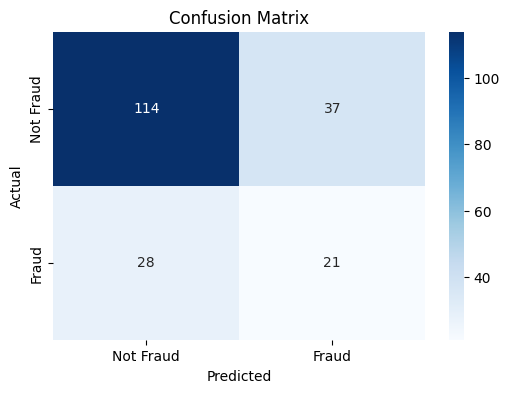

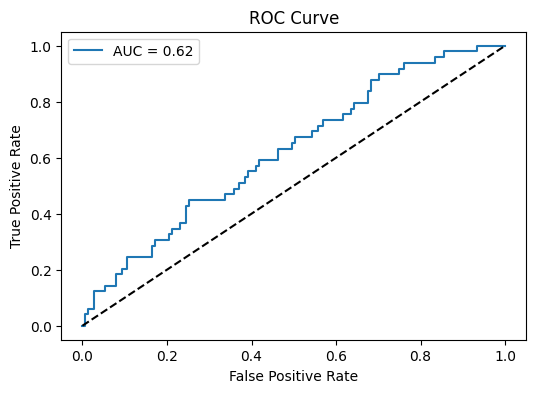

In [17]:
# Apply the optimal threshold to get final predictions
final_predictions = (y_test_probs >= best_threshold).astype(int)

# Use your function to evaluate the final performance
evaluate_model(y_test, final_predictions, y_test_probs)